# Part 2 - Monte Carlo Methods

In [1]:
import numpy as np
import cvxpy as cp
from grid_world import Grid_2 as ENV

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

## Helper Functions

In [2]:
"""
Selects a random starting state for gridworld exploration.

# Main function to choose starting positions for exploration
# Handles both random starts (exploring starts) and fixed starts

Args:
    env (object): Gridworld environment containing:
        # Grid dimensions
        - n_row (int): Number of rows in the gridworld  
        - n_col (int): Number of columns in the gridworld
        # Environment layout (2D array)
        - map (ndarray): Gridworld map where special cells are marked:
                       - Blue, green, black cells are excluded from selection
                       
    es (bool): Exploration strategy flag:
              # When True (exploring starts): returns random valid start state
              # When False: returns fixed default start state (23)

Returns:
    int: 
        # For es=True: Random valid start state index (row * n_col + col)
        # For es=False: Fixed start state index (23)
        # Note: Returned state index follows row-major ordering
"""
def exploring_starts(env, es=True):
    if es:
        while 1:
            # randomely select a position on the map
            row = np.random.choice([i for i in range(env.number_of_rows)])
            col = np.random.choice([i for i in range(env.number_of_columns)])
            if env.map[row][col] != 'T':
                break  # if the start is not terminal (Black), choose it

        return row * env.number_of_columns + col  # calculate the state number based on the place on the map
    else:
        return 23  # if don't explore starts, start from state 23

"""
Selects an index with maximum value from an array, breaking ties randomly.

Args:
    input_array (ndarray): 1D array of numerical values to search for maxima

Returns:
    int: Index of a maximum value element. If multiple maxima exist,
         returns one randomly selected from the maximal indices.
"""
def argmax_random(input_array):
    return np.random.choice(np.flatnonzero(input_array == np.max(input_array)))

"""
Visualizes a policy grid with colored cell highlights.

Creates a 5×5 grid visualization with:
- Policy symbols centered in each cell
- Semi-transparent colored overlays for specific cells:
  * Blue: (0,1)
  * Green: (0,4) 
  * Red: (4,2)
  * Yellow: (4,4)
  * Black: (2,0), (2,4), (4,0)

Coordinates follow matrix convention where (0,0) is top-left corner,
with first index as row (y) and second as column (x).
"""
def plot_symbolic_policy_from_symbols(symbol_grid, title="Optimal Policy"):
    N = 5  # Force 5x5 grid
    assert symbol_grid.shape == (N, N), "Symbol grid must be 5x5"

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Configure grid lines
    ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(N))  # x-axis labels 0-4 (bottom)
    ax.set_yticklabels(np.arange(N))  # y-axis labels 0-4 (left)
    
    # Grid styling
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
    ax.grid(which='major', alpha=0)
    ax.tick_params(axis='both', which='both', length=0)

    # Add colored overlays (semi-transparent)
    overlay_cells = [
        ((0, 1), 'blue', 0.3),     # (y,x), color, alpha
        ((0, 4), 'green', 0.3),
        ((4, 2), 'red', 0.3),
        ((4, 4), 'yellow', 0.3),
        ((2, 0), 'black', 0.3),    # New black cells
        ((2, 4), 'black', 0.3),
        ((4, 0), 'black', 0.3)
    ]
    for (y, x), color, alpha in overlay_cells:
        ax.add_patch(Rectangle(
            (x - 0.5, y - 0.5), 1, 1,  # (x,y) of bottom-left corner, width, height
            facecolor=color, alpha=alpha, edgecolor='none'
        ))

    # Plot symbols (centered)
    for i in range(N):
        for j in range(N):
            ax.text(j, i, symbol_grid[i, j], 
                   ha='center', va='center', 
                   fontsize=16, zorder=3)  # zorder ensures text is above patches

    # Grey border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('grey')
        spine.set_linewidth(1)

    ax.invert_yaxis()  # (0,0) at top-left
    plt.title(title)
    plt.tight_layout()
    plt.show()

"""
Converts a deterministic policy into visual arrow representations.

Transforms action indices into corresponding Unicode arrow symbols for clear
policy visualization in gridworld environments.

Args:
    policy (list[int]): Deterministic policy array where each element is an
                       action index (length = number_of_states)
    env (object): Environment configuration containing:
        - number_of_states (int): Total states in the gridworld
        - action_text (list[str]): Unicode arrow symbols mapping:
                                 [0] ← (Left)
                                 [1] ↓ (Down)
                                 [2] → (Right) 
                                 [3] ↑ (Up)

Returns:
    list[str]: Policy visualization array where each action index is replaced
              with its corresponding arrow symbol (length = number_of_states)
"""
def print_policy(policy, env):
    policy_visual = ['' for _ in range(env.number_of_states)]

    for s in range(env.number_of_states):
        lenth = len(policy[s])
        if lenth == 4:
            policy_visual[s] += 'o'  # 'o' means 4 directions are all available
        else:
            for a in range(lenth):
                policy_visual[s] += env.action_text[policy[s][a]]

    return policy_visual

def plot_value_function(V_pi_1, N=5, title="Value Function (0,0 at top-left)"):
    """
    Plots the value function with (0,0) at the top-left corner of the grid.
    Axis labels and displayed values match this layout.
    """
    # Reshape and flip the grid vertically to match (0,0) at top-left
    V_grid = np.flipud(V_pi_1.reshape(N, N))  # Flip rows

    # Create the plot
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="coolwarm", cbar=True,
                     linewidths=0.5, linecolor='black', square=True)

    # Invert y-axis to place row 0 at the top visually
    ax.invert_yaxis()

    # Set axis ticks and labels
    ax.set_xticks(np.arange(N) + 0.5)
    ax.set_yticks(np.arange(N) + 0.5)
    ax.set_xticklabels(np.arange(N))               # Column 0 on the left
    ax.set_yticklabels(np.arange(N)[::-1], rotation=0)  # Row 0 on top

    # Set title and layout
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 2.1.1 - Exploring Strats to learn an Optimal Policy

In [3]:
"""
Performs Monte Carlo Control with Exploring Starts to derive the optimal policy and value function.

This approach estimates the optimal policy by:
1. Generating episodes from randomly selected starting states (exploring starts)
2. Applying first-visit Monte Carlo returns to update action-value estimates (Q-values)
3. Iteratively refining the policy based on updated Q-values

Args:
    max_ep (int): Number of episodes to run for training (must be ≥ 1)
    gamma (float): Discount factor for future rewards (range: 0 to 1)
    env (object): Gridworld environment with the following attributes:
        - n_state (int): Total number of states in the environment
        - n_action (int): Number of available actions per state
        - model (ndarray): Transition dynamics array with shape 
                           (n_state, n_action, n_transitions, 4), where:
                           [..., 0]: Probability of transition (sum = 1 per state-action pair)
                           [..., 1]: Next state index
                           [..., 2]: Immediate reward for the transition
                           [..., 3]: Terminal flag (True if transition ends episode)

Returns:
    tuple:
        Q_all (ndarray): Estimated Q-function (state × action matrix)
        Q_opt (ndarray): Optimal state-value function (maximum Q-value per state)
        policy_opt (list): Derived optimal policy, where each element is a list 
                           of action(s) yielding the highest Q-value for that state
"""
def MCM_exploring_starts(max_episodes, gamma, env):
    # Initialize a simple deterministic policy: always pick action 0 initially
    learned_policy = [[0] for _ in range(env.number_of_states)]

    # Maintain a list of observed returns for each (state, action) pair
    returns_history = [[[] for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Initialize action-value estimates (Q-values) for each (state, action)
    q_values = [[0 for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Placeholder for the optimal state-value function
    optimal_state_values = [0 for _ in range(env.number_of_states)]

    for episode in range(max_episodes):
        state = exploring_starts(env, es=True)  # Randomly choose a starting state and action
        episode_trajectory = []  # Store sequence of (state, action, reward)

        # Generate an episode using an equiprobable random policy
        while True:
            action = np.random.randint(env.number_of_actions)  # Choose random action

            # Sample a transition from the environment model
            transitions = env.model[state][action]
            transition_probs = [transitions[i][0] for i in range(len(transitions))]
            selected_index = np.random.choice(len(transitions), p=transition_probs)
            _, next_state, reward, is_terminal = transitions[selected_index]

            episode_trajectory.append([state, action, reward])
            state = next_state

            if is_terminal:
                break

        # First-Visit Monte Carlo update: compute returns and update Q-values
        G = 0
        visited_state_actions = set()
        for step_index, (s, a, r) in enumerate(reversed(episode_trajectory)):
            G = gamma * G + r
            if (s, a) not in visited_state_actions:
                visited_state_actions.add((s, a))
                returns_history[s][a].append(G)
                q_values[s][a] = np.mean(returns_history[s][a])  # Average return

    # Derive the optimal policy and value function from Q-values
    for state in range(env.number_of_states):
        best_actions = np.argwhere(q_values[state] == np.max(q_values[state])).flatten().tolist()
        learned_policy[state] = best_actions

    optimal_state_values = np.max(q_values, axis=1)

    return q_values, optimal_state_values, learned_policy

## 2.1.2 - Epsilon-Soft approach to learn an Optimal Policy

In [4]:
"""
Performs Monte Carlo Control using ε-soft policies to estimate the optimal policy.

This method uses an ε-greedy strategy to ensure continuous exploration while learning,
allowing the policy to balance between trying new actions and exploiting known good ones.
It repeatedly:
1. Generates episodes using the current ε-soft policy
2. Updates Q-values using first-visit Monte Carlo returns
3. Improves the policy in an ε-soft manner to gradually move toward optimality

Args:
    max_ep (int): Number of training episodes to run (must be ≥ 1)
    gamma (float): Discount factor for future rewards (between 0 and 1)
    epsilon (float): Exploration rate (0 < ε ≤ 1), which controls:
                     - Chance of picking a random action (ε / num_actions)
                     - Chance of picking a greedy action (1 - ε + ε / num_actions)
    env (object): The RL environment, which should include:
        - n_state (int): Total number of states
        - n_action (int): Total number of actions
        - model (ndarray): Transition dynamics shaped as 
                           (n_state, n_action, n_outcomes, 4), with each outcome containing:
                           [0]: transition probability (p)
                           [1]: resulting state (s′)
                           [2]: reward (r)
                           [3]: terminal flag (True if episode ends)

Returns:
    tuple:
        Q_all (ndarray): Estimated Q-values for all state-action pairs
        Q_opt (ndarray): Optimal state-value function (max Q for each state)
        policy_opt (list): Optimal ε-soft policy represented as a list of optimal actions per state
"""
def MCM_epsilon_soft(max_episodes, gamma, epsilon, env):
    # Initialize an epsilon-soft policy (equal probability for all actions initially)
    policy = np.ones([env.number_of_states, env.number_of_actions]) / env.number_of_actions

    # Initialize deterministic optimal policy storage
    optimal_policy = [[0] for _ in range(env.number_of_states)]

    # Initialize return lists for each (state, action) pair
    returns = [[[] for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Initialize Q-values for each (state, action)
    Q_values = [[0 for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Initialize optimal value function (V*)
    V_optimal = [0 for _ in range(env.number_of_states)]

    for episode in range(max_episodes):
        state = exploring_starts(env, es=False)  # Use fixed starting state
        episode_trace = []  # To record (state, action, reward)

        # Generate one episode following current epsilon-soft policy
        while True:
            action = np.random.choice(np.arange(env.number_of_actions), p=policy[state])

            transitions = env.model[state][action]
            chosen_index = np.random.choice(len(transitions), p=[transitions[i][0] for i in range(len(transitions))])
            _, next_state, reward, done = transitions[chosen_index]

            episode_trace.append([state, action, reward])
            state = next_state

            if done:
                break

        # Backward return computation (Monte Carlo) with first-visit check
        G = 0
        visited_pairs = set()
        for step_idx, (s, a, r) in enumerate(reversed(episode_trace)):
            G = gamma * G + r

            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a))
                returns[s][a].append(G)
                Q_values[s][a] = np.mean(returns[s][a])

                # Find best action A* for state s using current Q
                A_star = argmax_random(Q_values[s])  # tie-breaking argmax

                # Update policy for state s based on epsilon-soft rule
                for action_id in range(env.number_of_actions):
                    if action_id == A_star:
                        policy[s, action_id] = 1 - epsilon + (epsilon / env.number_of_actions)
                    else:
                        policy[s, action_id] = epsilon / env.number_of_actions

    # Derive deterministic optimal policy from final epsilon-soft policy
    for s in range(env.number_of_states):
        best_actions = np.argwhere(policy[s] == np.max(policy[s])).flatten().tolist()
        optimal_policy[s] = best_actions

    V_optimal = np.max(Q_values, axis=1)

    return Q_values, V_optimal, optimal_policy

## Results

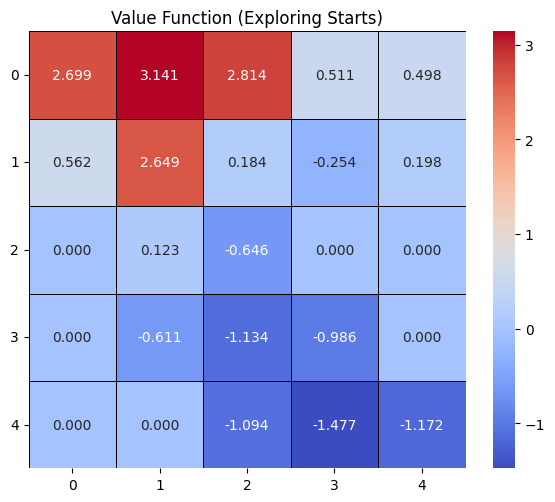

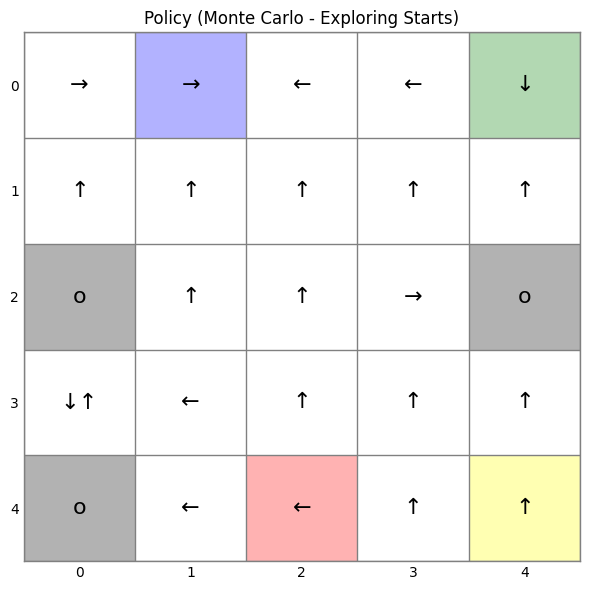

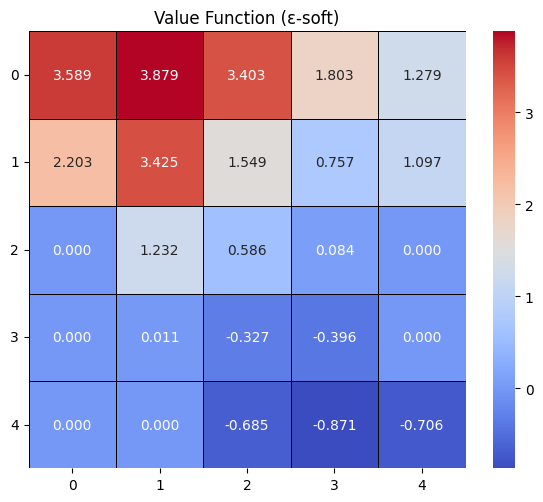

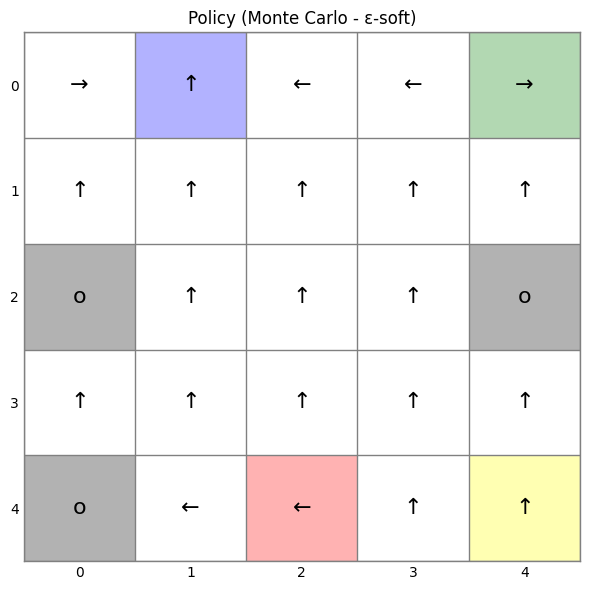

In [5]:
# Initialize the environment, set up parameters
max_ep = 5000
gam = 0.95
eps = 0.85  # epsilon, Algorithm parameter: small ϵ > 0
Env = ENV()

# Find the optimal policy
Q_1, Q_opt_1, pol_opt_1 = MCM_exploring_starts(max_ep, gam, Env)
Q_2, Q_opt_2, pol_opt_2 = MCM_epsilon_soft(max_ep, gam, eps, Env)

# Convert policy strings to grid format for plotting
N = Env.number_of_rows  # assuming square grid

# --- Monte Carlo with Exploring Starts ---
policy_symbols_1 = np.array(print_policy(pol_opt_1, Env)).reshape(N, N)
plot_value_function(np.array(Q_opt_1), title="Value Function (Exploring Starts)")
plot_symbolic_policy_from_symbols(policy_symbols_1, title="Policy (Monte Carlo - Exploring Starts)")

# --- Monte Carlo with ϵ-soft ---
policy_symbols_2 = np.array(print_policy(pol_opt_2, Env)).reshape(N, N)
plot_value_function(np.array(Q_opt_2), title="Value Function (ε-soft)")
plot_symbolic_policy_from_symbols(policy_symbols_2, title="Policy (Monte Carlo - ε-soft)")

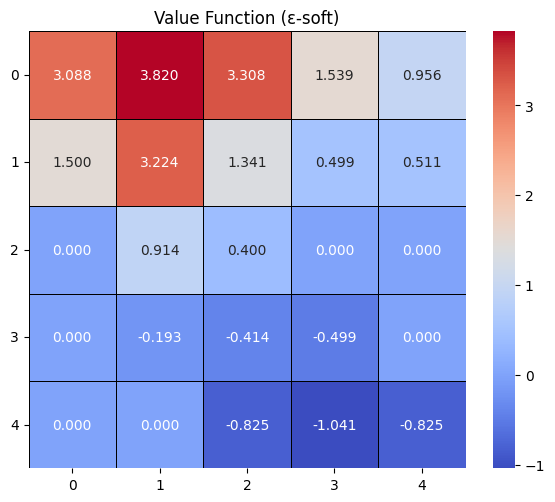

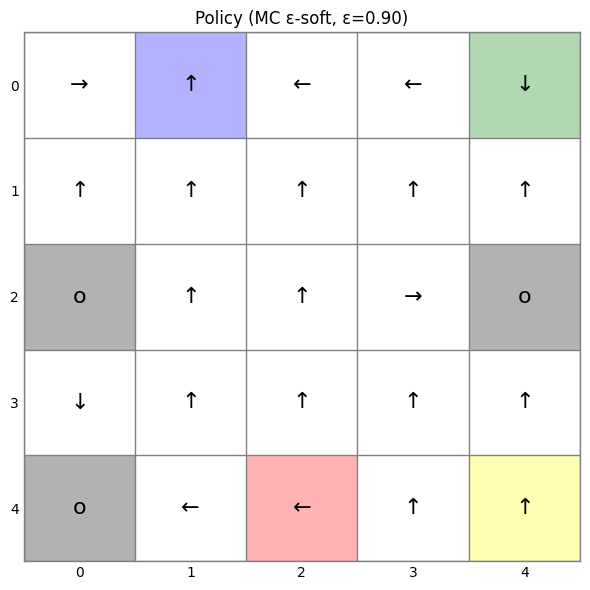

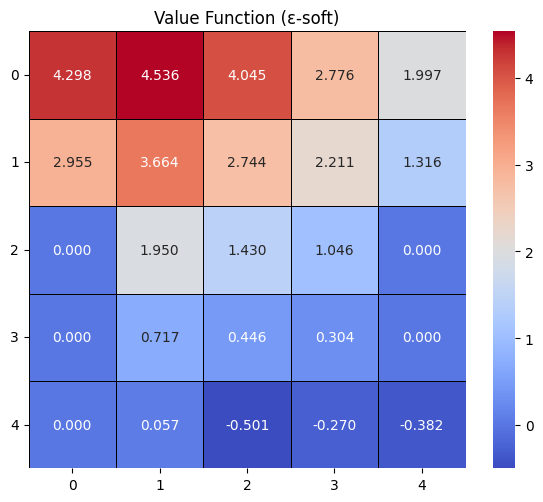

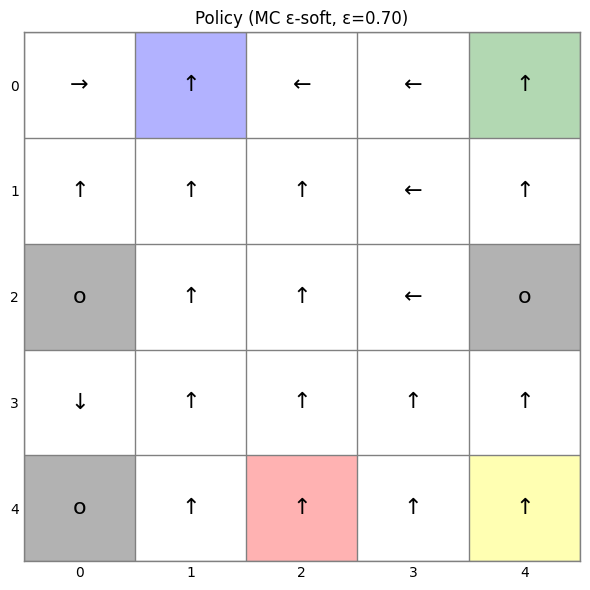

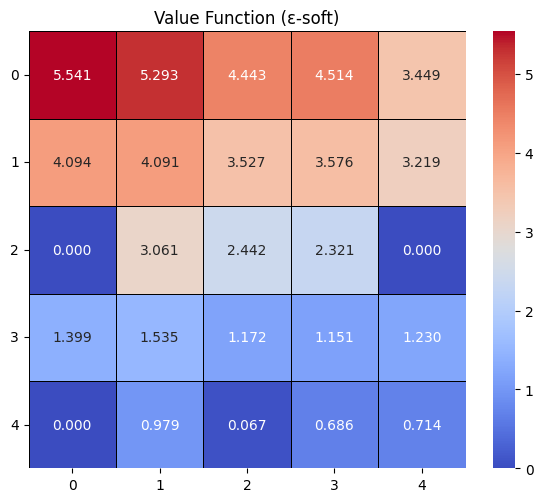

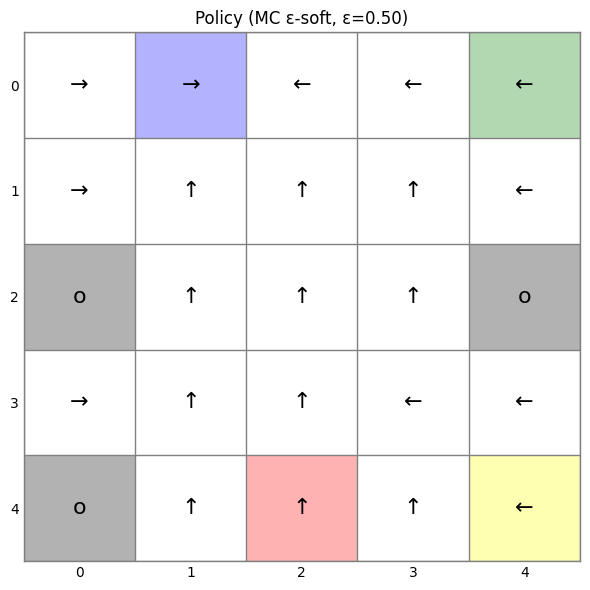

In [6]:
max_ep = 5000
eps = 0.90
Q_2_1, Q_opt_2_1, pol_opt_2_1 = MCM_epsilon_soft(max_ep, gam, eps, Env)

max_ep = 1000
eps = 0.70
Q_2_2, Q_opt_2_2, pol_opt_2_2 = MCM_epsilon_soft(max_ep, gam, eps, Env)

max_ep = 500
eps = 0.50
Q_2_3, Q_opt_2_3, pol_opt_2_3 = MCM_epsilon_soft(max_ep, gam, eps, Env)


N = Env.number_of_rows  # Grid size

# --- ε = 0.90 ---
policy_symbols_2_1 = np.array(print_policy(pol_opt_2_1, Env)).reshape(N, N)
plot_value_function(np.array(Q_opt_2_1), title="Value Function (ε-soft)")
plot_symbolic_policy_from_symbols(policy_symbols_2_1, title="Policy (MC ε-soft, ε=0.90)")

# --- ε = 0.70 ---
policy_symbols_2_2 = np.array(print_policy(pol_opt_2_2, Env)).reshape(N, N)
plot_value_function(np.array(Q_opt_2_2), title="Value Function (ε-soft)")
plot_symbolic_policy_from_symbols(policy_symbols_2_2, title="Policy (MC ε-soft, ε=0.70)")

# --- ε = 0.50 ---
policy_symbols_2_3 = np.array(print_policy(pol_opt_2_3, Env)).reshape(N, N)
plot_value_function(np.array(Q_opt_2_3), title="Value Function (ε-soft)")
plot_symbolic_policy_from_symbols(policy_symbols_2_3, title="Policy (MC ε-soft, ε=0.50)")

## 2.2 - Using Behaviour Policy with Equiprobable moves to learn an Optimal Policy

In [7]:
"""
Applies Monte Carlo Control using an equiprobable behavior policy for off-policy learning.

This method learns the optimal policy by:
1. Exploring the environment uniformly—each action has an equal chance of being chosen
2. Using first-visit Monte Carlo returns to evaluate action values
3. Updating the target policy greedily based on the learned Q-values

This setup is useful for off-policy learning, where the behavior policy (used for sampling)
differs from the target policy (which is optimized).

Args:
    max_ep (int): Number of training episodes to run (must be ≥ 1)
    gamma (float): Discount factor for future rewards (range: 0 to 1)
    env (object): The environment, expected to have:
        - n_state (int): Total number of discrete states
        - n_action (int): Number of possible actions per state
        - model (ndarray): Transition model with shape 
                           (n_state, n_action, n_transitions, 4), where:
                           [0]: Probability of the transition
                           [1]: Next state index
                           [2]: Immediate reward
                           [3]: Terminal flag (True if episode ends)

Returns:
    tuple:
        Q_all (ndarray): Full Q-function representing value estimates for all (state, action) pairs
        Q_opt (ndarray): Optimal value function derived by taking the max Q-value per state
        policy_opt (list): Optimal policy where each state maps to a list of the best action(s)
"""
def MCM_behaviour_policy(max_episodes, gamma, env):
    # Initialize a simple deterministic policy (initially taking action 0 in all states)
    learned_policy = [[0] for _ in range(env.number_of_states)]

    # Initialize Q-function with small negative values
    q_values = [[-0.21 for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Initialize the optimal state-value function
    state_values = [0.0 for _ in range(env.number_of_states)]

    # Initialize cumulative importance weights for each (state, action) pair
    cumulative_weights = [[0.0 for _ in range(env.number_of_actions)] for _ in range(env.number_of_states)]

    # Initialize greedy policy derived from Q-values (used for importance sampling)
    greedy_policy = np.argmax(q_values, axis=1)

    # Define behavior policy: uniform random across all actions
    behavior_policy = np.ones([env.number_of_states, env.number_of_actions]) / env.number_of_actions

    for episode in range(max_episodes):
        # Choose a random start state using exploring starts
        current_state = exploring_starts(env, es=True)

        episode_trajectory = []  # To store (state, action, reward) for the episode

        # --- Generate an episode under the behavior policy ---
        while True:
            # Choose an action from the behavior policy
            action = np.random.choice(np.arange(env.number_of_actions), p=behavior_policy[current_state])

            # Sample a transition (next_state, reward, terminal) from the environment model
            transitions = env.model[current_state][action]
            chosen_transition = np.random.choice(
                range(len(transitions)), p=[t[0] for t in transitions]
            )
            _, next_state, reward, is_terminal = transitions[chosen_transition]

            # Store the step in the trajectory
            episode_trajectory.append([current_state, action, reward])

            current_state = next_state

            if is_terminal:
                break

        # --- Backward pass: Off-policy Monte Carlo updates using importance sampling ---
        G = 0  # Return
        W = 1  # Importance sampling weight

        for state, action, reward in reversed(episode_trajectory):
            G = gamma * G + reward  # Update return
            cumulative_weights[state][action] += W  # Update cumulative weight
            # Incremental update of Q-value using weighted return
            q_values[state][action] += (W / cumulative_weights[state][action]) * (G - q_values[state][action])

            # Update the greedy policy from current Q-values
            greedy_policy[state] = np.argmax(q_values[state])

            # Stop updating if action taken deviates from greedy policy
            if action != greedy_policy[state]:
                break

            # Update importance weight
            W = W / behavior_policy[state][action]

    # --- Extract final optimal policy and state values ---
    for state in range(env.number_of_states):
        best_actions = np.argwhere(q_values[state] == np.max(q_values[state])).flatten()
        learned_policy[state] = best_actions.tolist()

    state_values = np.max(q_values, axis=1)

    return q_values, state_values, learned_policy

## Results

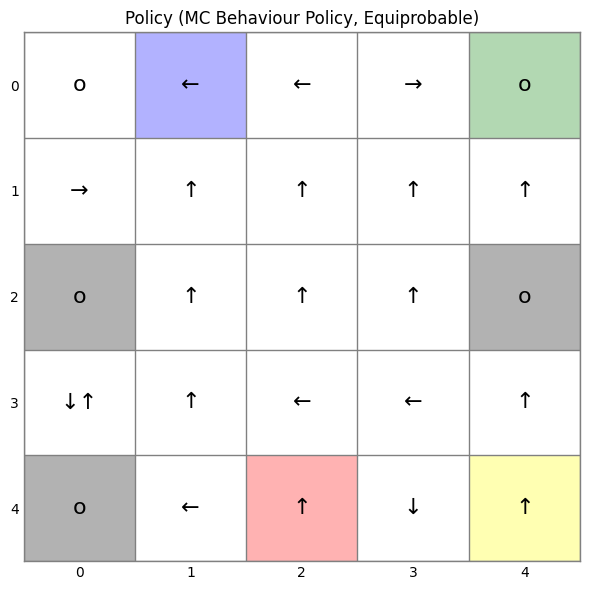

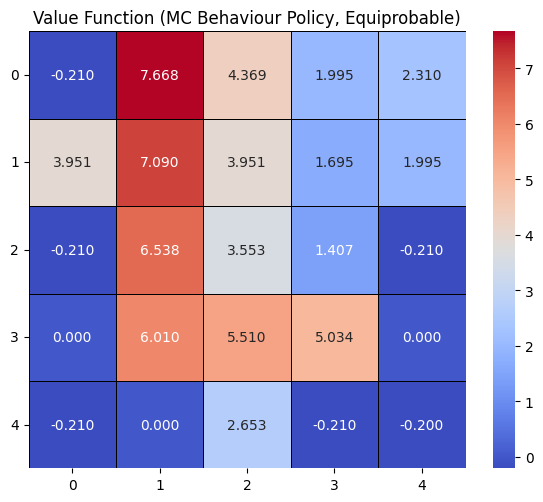

In [9]:
# Initialize the environment, set up parameters
max_ep = 200000
gam = 0.95
Env = ENV()

# Find the optimal policy
Q_3, Q_opt_3, pol_opt_3 = MCM_behaviour_policy(max_ep, gam, Env)


# Convert policy to symbol grid and reshape for plotting
policy_symbols_3 = np.array(print_policy(pol_opt_3, Env)).reshape(Env.number_of_rows, Env.number_of_columns)

# Plot the symbolic policy
plot_symbolic_policy_from_symbols(policy_symbols_3, title="Policy (MC Behaviour Policy, Equiprobable)")
plot_value_function(np.array(Q_opt_3), title="Value Function (MC Behaviour Policy, Equiprobable)")

